* [x] ignore illegal action
* [x] penalize revisiting states
* [ ] penalize too many steps
* [x] net use cov, output depends on input
* agent: 
* * [x] DQL
* * [ ] A3C
* * [ ] REINFORCE
* loss? measure performance? optimal path? 

------------------------------

* loss is much more well-behaved after embedding!
* only 6 playable config with 342.. how to make model generalize better?
* how to penalize loops?
* how to find optimal steps?
* reward enjineering is very important!!!

In [1]:
import random
import copy
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
from gym import spaces

from config_3_4_2 import config_3_4_2

In [2]:
a = {str(i) for i in config_3_4_2}
len(a)

6

In [66]:
class Board:
    def __init__(self, num_color: int, max_length: int, empty: int = 2):
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty
        self.flasks = np.full((self.tubes, self.max_length), -1, dtype=np.int16)

        self.idx = np.zeros(self.tubes, dtype=np.uint16)
        self.idx[:self.num_color] = self.max_length

        self.actions = []
        self.states = set()

    def __str__(self):
        return str(self.flasks)

    def __repr__(self):
        return str(self.flasks)

    def __iter__(self):
        return iter(self.flasks)

    def __len__(self):
        return len(self.flasks)

    def __getitem__(self, item):
        return self.flasks[item]

    def grid_to_state(self) -> List[List[int]]:
        state = []
        for r in self:
            state.append([])
            for c in r:
                if c != -1:
                    state[-1].append(c)
        return state

    def state_to_grid(self, state: List[List[int]]):
        self.flasks.fill(-1)
        self.idx.fill(0)
        self.actions = []
        self.states = set()
        for i, r in enumerate(state):
            self.idx[i] = len(r)
            for j, c in enumerate(r):
                self.flasks[i][j] = c

    def is_flask_full(self, i: int) -> bool:
        return self.idx[i] == self.max_length

    def is_flask_empty(self, i: int) -> bool:
        return self.idx[i] == 0

    def has_one_color(self, i: int) -> bool:
        if self.idx[i] == 0:
            return True
        return (self.flasks[i][:self.idx[i]] == self.flasks[i][0]).all()

    def is_flask_solved(self, i: int) -> bool:
        if self.is_flask_empty(i) or (self.is_flask_full(i) and self.has_one_color(i)):
            return True
        return False

    def top(self, i: int) -> int:
        return self.flasks[i][self.idx[i]-1]

    def pop(self, i: int) -> int:
        ball = self.flasks[i][self.idx[i]-1]
        self.flasks[i][self.idx[i] - 1] = -1
        self.idx[i] -= 1
        return ball

    def push(self, i: int, ball: int):
        self.flasks[i][self.idx[i]] = ball
        self.idx[i] += 1

    def is_push_allowed(self, i: int, ball: int) -> bool:
        if self.is_flask_empty(i) or (self.top(i) == ball and not self.is_flask_full(i)):
            return True
        return False

    def is_invalid_init_state(self) -> bool:
        return any(self.is_flask_full(i) and self.has_one_color(i) for i in range(self.tubes))

    def is_solved(self) -> bool:
        return all(self.is_flask_solved(i) for i in range(self.tubes))

    def reward(self) -> int:
        if self.is_solved():
            return 10 * self.max_length * self.num_color + 100
        if str(self) in self.states:
            return -10
        return sum(10 * int(self.has_one_color(i)) * self.idx[i] for i in range(self.tubes))

    def valid_actions(self) -> List[Tuple[int, int]]:
        actions = []
        for i in range(self.tubes):
            if self.is_flask_solved(i):
                continue
            if self.is_flask_empty(i):
                continue
            top_i = self.top(i)
            for j in range(self.tubes):
                if i != j and self.is_push_allowed(j, top_i):
                    actions.append((i, j))
        return actions

    def play(self, action: Tuple[int, int]):
        self.push(action[1], self.pop(action[0]))
        self.actions.append(action)

    def undo_action(self):
        action = self.actions.pop()
        self.push(action[0], self.pop(action[1]))

    def dfs_solve(self, steps: int = 0, path: List["Board"] = []) -> Tuple[bool, int, List["Board"]]:
        if self.is_solved():
            return True, steps, path
        # if self.is_deadend():
        #     return False, steps, path
        for a in self.valid_actions():
            self.play(a)
            current_state = str(self)
            if current_state in self.states:
                self.undo_action()
                continue
            self.states.add(current_state)
            path.append(copy.deepcopy(self))
            r = self.dfs_solve(steps+1)
            if r[0]:
                return r
            self.undo_action()
        return False, steps, path

In [67]:
class BallSort(gym.Env):

    metadata = {"render_modes": ["human", "silent", "cli"]}

    cmap = colors.ListedColormap(['#000000', '#e4572e', '#1b998b', '#29335c', '#f3a712', '#669bbc', '#ed217c', '#58355e', '#f39c6b', '#ca907e', '#aeb7b3', '#c0b9dd', '#a8c686'])

    def __init__(self, num_color: int = 3, max_length: int = 4, empty: int = 2):
        super(BallSort, self).__init__()
        self.env_name = 'ball-sort-puzzle'
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty

        self.arr = np.array(list(range(num_color)) * max_length).reshape(num_color, max_length)
        self.board = Board(self.num_color, self.max_length, self.empty)
        self.steps = 0

        self.data = set()

        self.action_space = spaces.Box(low=0, high=self.tubes - 1, shape=(2,), dtype=int)
        self.observation_space = spaces.Box(low=-1, high=self.num_color-1, shape=(self.tubes, self.max_length), dtype=int)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        """make an env"""
#         solvable = False
#         temp_board = Board(self.num_color, self.max_length, self.empty)
#         while not solvable:
#             np.random.shuffle(self.arr)
#             temp_board.state_to_grid(self.arr.tolist())
#             if not temp_board.is_invalid_init_state() and str(temp_board) not in self.data:
#                 self.data.add(str(temp_board))
#                 solvable, steps, path = temp_board.dfs_solve()

#         self.board.state_to_grid(self.arr.tolist())
#         self.render()

        """load from file"""
        self.board.state_to_grid(random.choice(config_3_4_2))
        steps = 0
        self.render()
        return self.board.flasks, steps

    def step(self, action: Tuple[int, int]):
        assert action in self.board.valid_actions(), "action must be playable!!"
        self.board.play(action)
        self.steps += 1
        reward = self.board.reward()
        solved = self.board.is_solved()
        self.board.states.add(str(self.board))
        self.render(reward)

        return self.board.flasks, reward, solved, {"steps": self.steps}

    def render(self, reward=None):
        if self.render_mode == "cli":
            print("====================================================")
            print("Step:", self.steps)
            print(self.board.grid_to_state())
            print("State Reward:", reward if reward else self.board.reward())
            print("Is solved:", self.board.is_solved())
            print("====================================================")
        elif self.render_mode == "human":
            # plt.figure(figsize=(self.tubes, self.max_length))
            plt.imshow(self.board.flasks.T[::-1], cmap=self.cmap)
            plt.title(f"Step: {self.steps}. Reward: {reward if reward else self.board.reward()}. Solved: {self.board.is_solved()}")
            plt.axis("off")
            plt.show()

In [68]:
class Model(nn.Module):
    def __init__(self, num_color, max_length, empty, p=0.2):
        super().__init__()
        # max 12 balls + 1 for empty
        self.em = nn.Embedding(num_embeddings=num_color+1, embedding_dim=3, padding_idx=0)
        self.cnn = [nn.Conv2d(3, 16, (3, 1))]
        self.bn = [nn.BatchNorm2d(16)]
        self.drop = nn.Dropout(p=p)
        self.mp = nn.MaxPool2d(2)
        self.flat = nn.Flatten()

        flat_shape = 16 * ((num_color + empty - 2) // 2) * (max_length // 2)
        log_2 = int(np.ceil(np.log2(flat_shape)))
        # print(flat_shape, log_2)
        self.fc = [nn.Linear(flat_shape, 2 ** (log_2 + 2)), nn.Linear(2 ** (log_2 + 2), 2 ** (log_2 + 1))]
        self.out = nn.Linear(2 ** (log_2 + 1), (num_color + empty) ** 2)

    def forward(self, x):
        # print(x.size())
        x = self.em(x+1)
        # print(x.size())
        x = x.permute(0, 3, 1, 2)
        # print(x.size())

        for i in range(len(self.cnn)):
            x = self.cnn[i](x)
            x = self.bn[i](x)
            x = F.relu(x)
            # print(x.size())
            x = self.mp(x)
            x = self.drop(x)
            # print(x.size())

        x = self.flat(x)
        # print(x.size())
        for i in range(len(self.fc)):
            x = self.fc[i](x)
            x = F.relu(x)
            # print(x.size())
        x = self.out(x)
        # print(x.size())
        return x

In [73]:
class DQN:

    def __init__(self, num_color, max_length, empty, batch_size, memory_capacity, q_network_iteration, epsilon, lr, delta, gamma, device):
        self.device = device
        # env set up
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty
        self.num_actions = self.tubes * self.tubes
        self.num_states = self.tubes * self.max_length

        self.env = BallSort(self.num_color, self.max_length, self.empty)

        # buffer replay set up
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.q_network_iteration = q_network_iteration
        self.learn_step_counter = 0
        self.memory_counter = 0

        # state, action, reward, next state, mask
        # self.memory = np.zeros((self.memory_capacity, self.num_states * 2 + 2 + self.num_actions)) 
        self.memory = np.zeros((self.memory_capacity, self.num_states * 2 + 2)) 

        # neural network
        self.epsilon = epsilon

        self.lr = lr
        self.delta = delta
        self.gamma = gamma

        self.eval_net = Model(self.num_color, self.max_length, self.empty).to(self.device)
        self.target_net = Model(self.num_color, self.max_length, self.empty).to(self.device)
        self.target_net.load_state_dict(self.eval_net.state_dict())

        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)
        self.criterion = torch.nn.HuberLoss(delta=self.delta).to(self.device)

    def get_mask(self):
        allowed_actions = self.env.board.valid_actions()
        allowed_actions_linear = [i * self.tubes + j for i, j in allowed_actions]
        mask = torch.ones(self.num_actions, dtype=bool).to(self.device)
        mask[allowed_actions_linear] = False
        return mask

    def choose_random_valid_action(self):
        allowed_actions = self.env.board.valid_actions()
        return random.choice(allowed_actions), self.get_mask()

    def choose_random_action(self):
        action = random.randint(0, self.num_actions-1)
        i = action // (self.tubes)
        j = action % (self.tubes)
        action = (i, j)
        return action

    def choose_best_valid_action(self, state):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0))
            action_probs[:, mask] = -np.inf
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.tubes)
            j = action % (self.tubes)
            action = (i, j)
            return action, mask

    def choose_best_action(self, state):
        with torch.no_grad():
            action_probs = self.eval_net(state.unsqueeze(0))
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.tubes)
            j = action % (self.tubes)
            action = (i, j)
            return action

    def choose_action(self, state, evaluation=False):
        if evaluation:
            return self.choose_best_valid_action(state)
        else:
            if np.random.randn() < self.epsilon:
                return self.choose_random_valid_action()
            else:
                return self.choose_best_valid_action(state)

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state.view(-1).cpu().numpy(),
                                [action, reward],
                                # mask.view(-1).cpu().numpy(),
                                next_state.reshape(-1)))
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # update the parameters
        if self.learn_step_counter % self.q_network_iteration == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch from memory
        sample_index = np.random.choice(self.memory_capacity, self.batch_size)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.LongTensor(batch_memory[:, :self.num_states]).view(self.batch_size, self.tubes, self.max_length).to(self.device)
        batch_action = torch.LongTensor(batch_memory[:, self.num_states:self.num_states+1]).to(self.device)
        batch_reward = torch.FloatTensor(batch_memory[:, self.num_states+1:self.num_states+2]).to(self.device)
        # batch_mask = torch.tensor(batch_memory[:, self.num_states+2:self.num_states+2+self.num_actions], dtype=torch.bool).to(self.device)
        batch_next_state = torch.LongTensor(batch_memory[:, -self.num_states:]).view(self.batch_size, self.tubes, self.max_length).to(self.device)

        # q_eval
        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + self.gamma * q_next.max(1)[0].view(self.batch_size, 1)

        loss = self.criterion(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, episodes=500, plot=False):
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []
        for i in range(1, episodes+1):
            self.epsilon = max(0, 0.9*(1-(i)/100))
            state, dfs_steps = self.env.reset()
            ep_reward = 0
            done = False
            loss = []
            while not done:
                state = torch.LongTensor(state).to(self.device)
                action, _ = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                self.store_transition(state, action[0] * self.tubes + action[1], reward, next_state)
                ep_reward += reward

                if self.memory_counter >= self.memory_capacity:
                    loss.append(self.learn())
                state = next_state
            step_list.append(info['steps'])
            reward_list.append(ep_reward)
            loss_list.append(np.mean(loss))
            if plot and ((i) % 50 == 0 or i == episodes):
                print(f"Episode: {i}, Steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {np.mean(loss)}, eps: {self.epsilon}")
                fig, ax = plt.subplots(3)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(step_list, 'g-', label='total_steps')
                ax[2].legend(loc="upper left")
                plt.show()

        return reward_list, step_list, loss_list

    def evaluate(self, render=False):
        if render:
            self.env.render_mode = "human"
        states = []
        self.eval_net.eval()
        with torch.no_grad():
            state, dfs_steps = self.env.reset()
            ep_reward = 0
            done = False
            while not done:
                states.append(copy.deepcopy(state))

                state = torch.LongTensor(state).to(self.device)
                action, _ = self.choose_action(state, True)

                next_state, reward, done, info = self.env.step(action)
                ep_reward += reward
                state = next_state
            states.append(state)
        return states, ep_reward, info["steps"], dfs_steps

/home/alghra0e/rl/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alghra0e/rl/env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 50, Steps: 41, dfs_steps: 0, reward: 2470, loss 53.321581398568505, eps: 0.45


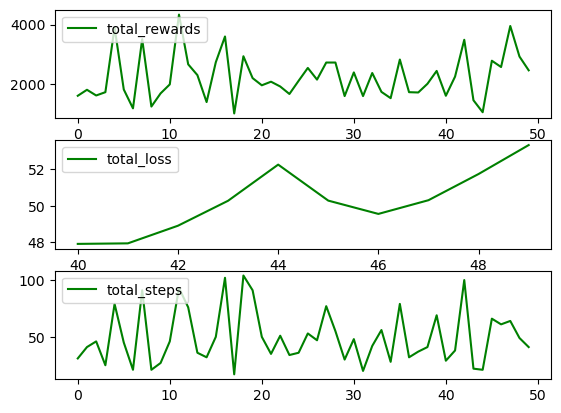

Episode: 100, Steps: 21, dfs_steps: 0, reward: 1160, loss 50.55510947817848, eps: 0


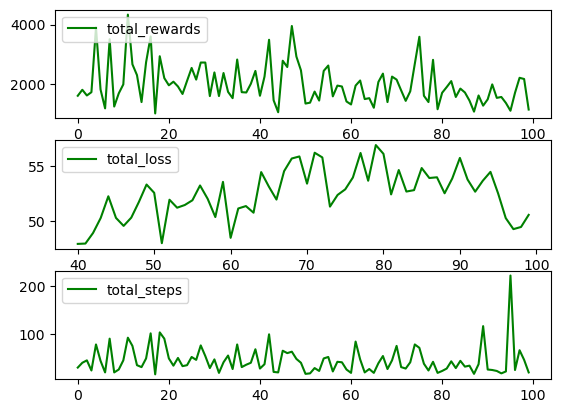

Episode: 150, Steps: 41, dfs_steps: 0, reward: 2070, loss 44.81922889337307, eps: 0


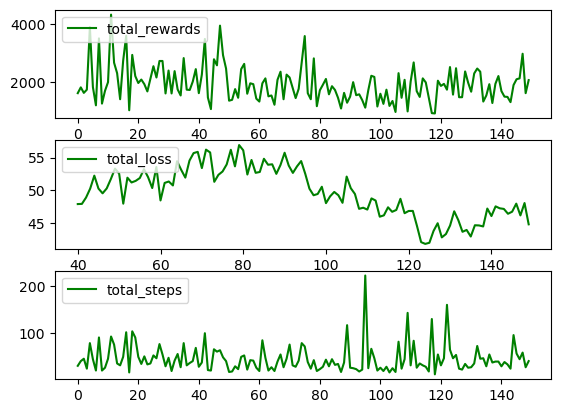

Episode: 200, Steps: 29, dfs_steps: 0, reward: 1620, loss 48.399389858903554, eps: 0


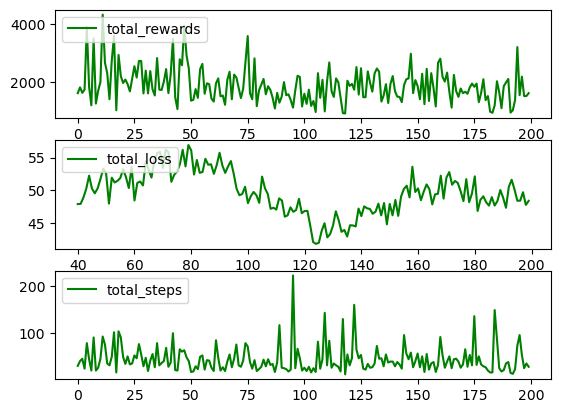

In [74]:
# hyper-parameters

NUM_COLOR = 3
MAX_LENGTH = 4
EMPTY = 2

EPSILON = 0.99

BATCH_SIZE = 32
MEMORY_CAPACITY = 2000
Q_NETWORK_ITERATION = 100

LR = 0.0001
DELTA = 1.0
GAMMA = 0.90

EPISODES = 200

DEVICE = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 100
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

dqn = DQN(NUM_COLOR, MAX_LENGTH, EMPTY, BATCH_SIZE, MEMORY_CAPACITY, Q_NETWORK_ITERATION, EPSILON, LR, DELTA, GAMMA, DEVICE)
reward_list, step_list, loss_list = dqn.train(EPISODES, True)

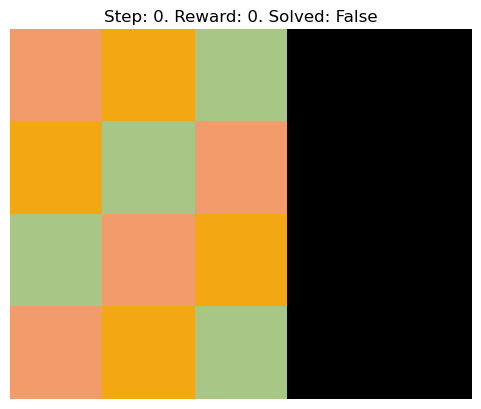

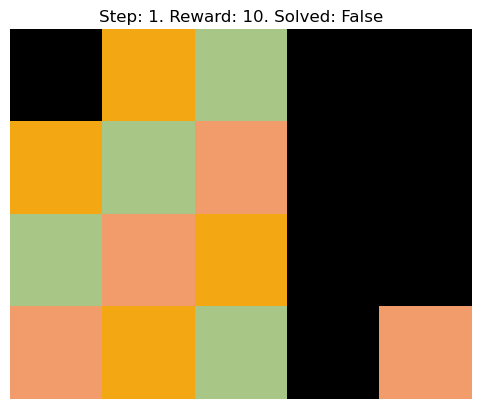

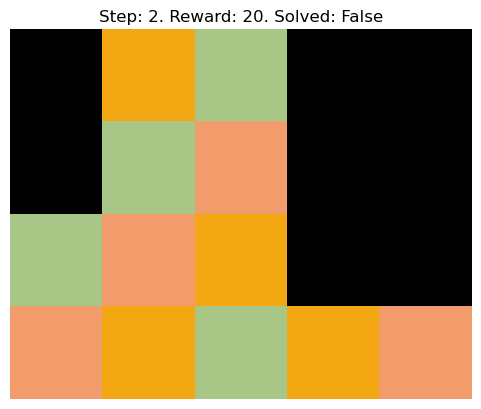

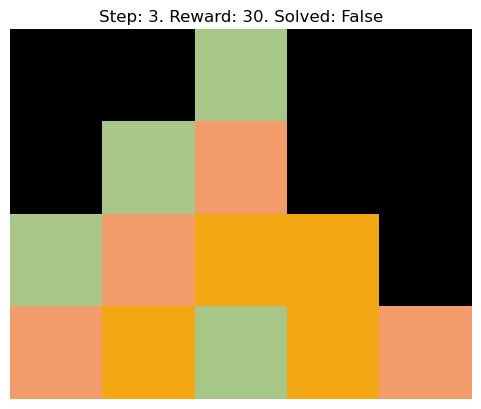

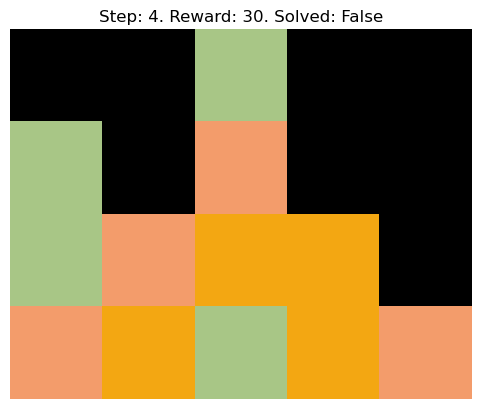

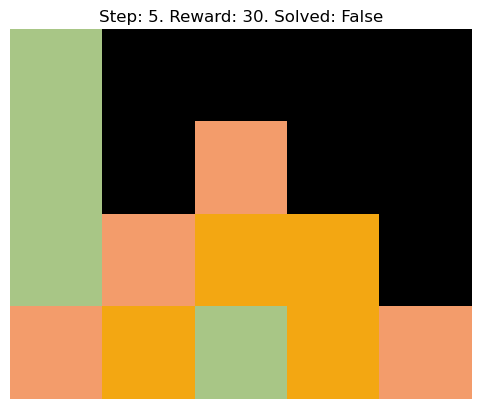

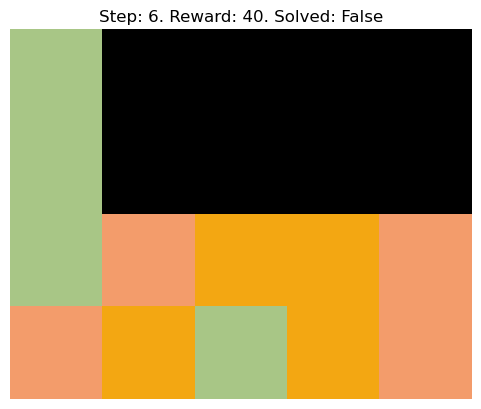

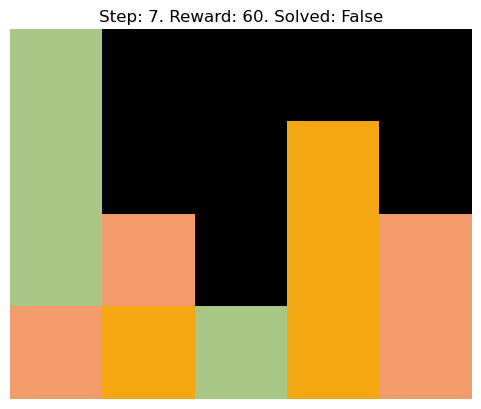

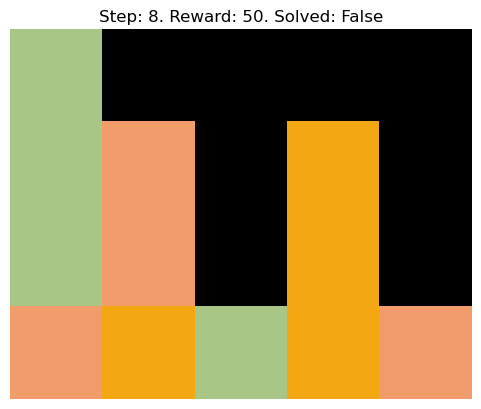

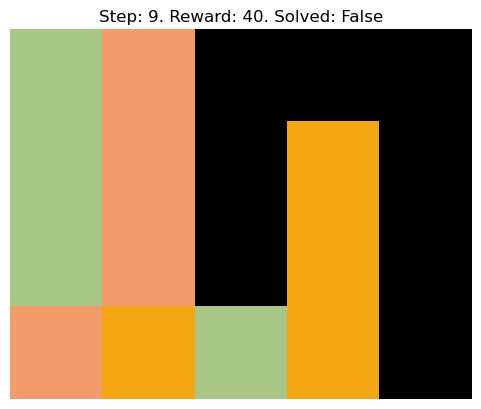

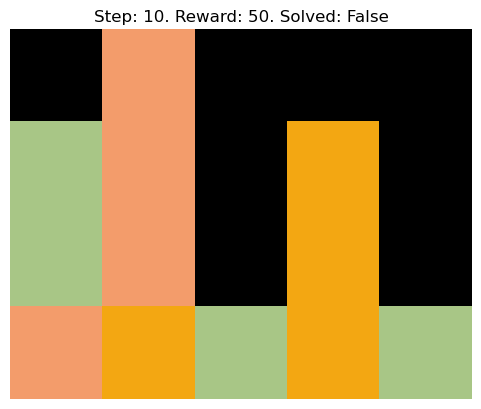

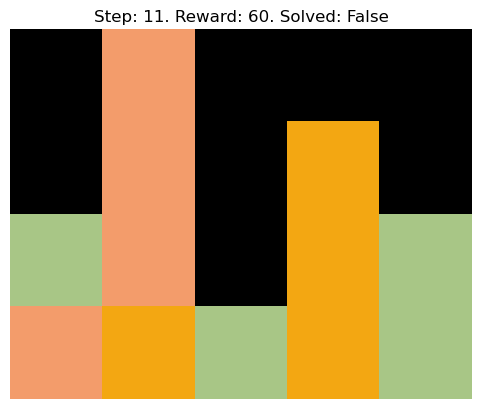

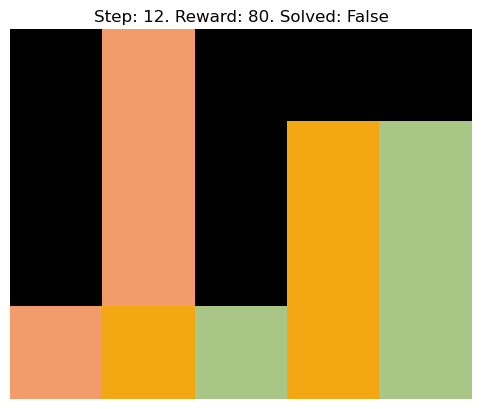

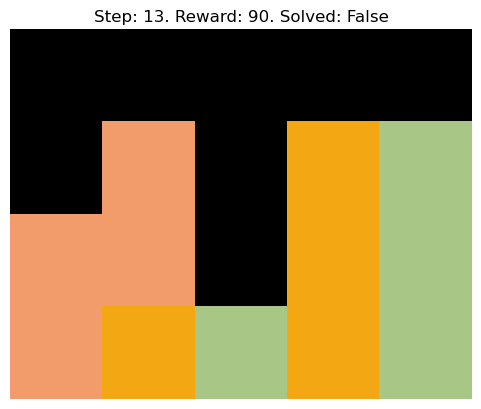

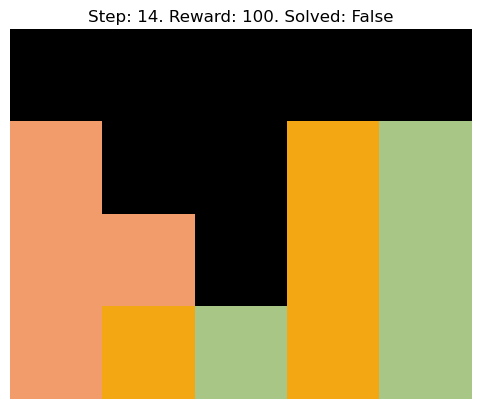

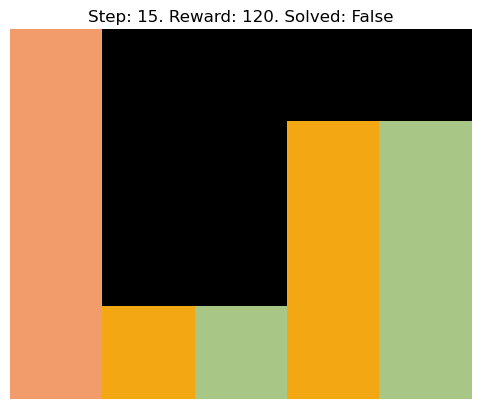

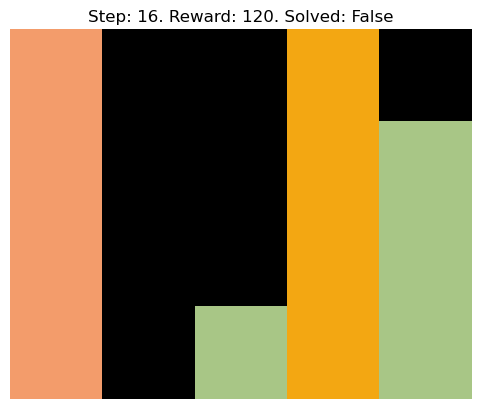

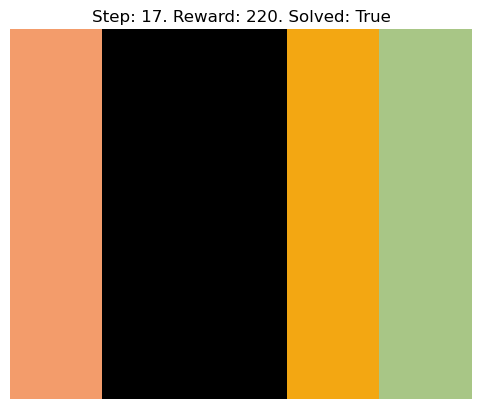

([array([[ 1,  2,  0,  1],
         [ 0,  1,  2,  0],
         [ 2,  0,  1,  2],
         [-1, -1, -1, -1],
         [-1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  0, -1],
         [ 0,  1,  2,  0],
         [ 2,  0,  1,  2],
         [-1, -1, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2, -1, -1],
         [ 0,  1,  2,  0],
         [ 2,  0,  1,  2],
         [ 0, -1, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2, -1, -1],
         [ 0,  1,  2, -1],
         [ 2,  0,  1,  2],
         [ 0,  0, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  2, -1],
         [ 0,  1, -1, -1],
         [ 2,  0,  1,  2],
         [ 0,  0, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  2,  2],
         [ 0,  1, -1, -1],
         [ 2,  0,  1, -1],
         [ 0,  0, -1, -1],
         [ 1, -1, -1, -1]], dtype=int16),
  array([[ 1,  2,  2,  2],
         [ 0,  1, -1, -1],
         [ 2,  0, -1, -1],
         [ 0,  0, -

In [75]:
dqn.evaluate(True)

In [ ]:
fig = plt.figure()
im = plt.imshow(states[0].T[::-1], cmap=dqn.env.cmap)
plt.title(f"Iteration: {0}")
plt.axis("off")


def init():
    im.set_data(states[0].T[::-1])


def animate(i):
    plt.title(f"Iteration: {i}")
    im.set_data(states[i].T[::-1])
    return im


anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(states), interval=5)
anim.save